# Gradient Boosting Machines (GBMs) with XGBoost


![](https://i.imgur.com/6MYc56a.png)


Let's begin by installing the required libraries.

In [1]:
!pip install numpy pandas matplotlib seaborn --quiet

In [2]:
!pip install jovian opendatasets xgboost graphviz lightgbm scikit-learn xgboost lightgbm --upgrade --quiet

     |████████████████████████████████| 68 kB 6.1 MB/s 
     |████████████████████████████████| 255.9 MB 41 kB/s 
     |████████████████████████████████| 47 kB 5.1 MB/s 
     |████████████████████████████████| 2.0 MB 70.1 MB/s 


## Problem Statement

This tutorial takes a practical and coding-focused approach. We'll learn gradient boosting by applying it to a real-world dataset from the [Rossmann Store Sales](https://www.kaggle.com/c/rossmann-store-sales) competition on Kaggle:

> Rossmann operates over 3,000 drug stores in 7 European countries. Currently, Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality. 
>
>
> With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied. You are provided with historical sales data for 1,115 Rossmann stores. The task is to forecast the "Sales" column for the test set. Note that some stores in the dataset were temporarily closed for refurbishment.
>
> View and download the data here: https://www.kaggle.com/c/rossmann-store-sales/data

## Downloading the Data


In [3]:
import os
import opendatasets as od
import pandas as pd
pd.set_option("display.max_columns", 120)
pd.set_option("display.max_rows", 120)

Let's load the data into Pandas dataframes.

In [4]:
ross_df = pd.read_csv('train.csv',low_memory=False)
store_df = pd.read_csv('store.csv')

## EDA

In [5]:
def split_date(df):
    df['Date'] = pd.to_datetime(df['Date'])
    df['Year'] = df.Date.dt.year
    df['Month'] = df.Date.dt.month
    df['Day'] = df.Date.dt.day
    df['WeekOfYear'] = df.Date.dt.isocalendar().week

In [6]:
df_eda = ross_df.copy()
df_eda = df_eda[df_eda["Open"] == 1].reset_index(drop=True)
split_date(df_eda)
df_eda.head(3)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear
0,1,5,2015-07-31,5263.0,555.0,1.0,1.0,0,1.0,2015,7,31,31
1,2,5,2015-07-31,6064.0,625.0,1.0,1.0,0,1.0,2015,7,31,31
2,3,5,2015-07-31,8314.0,821.0,1.0,1.0,0,1.0,2015,7,31,31


In [28]:
import plotly.express as px

In [30]:
axis = df_eda.groupby('Month')[['Sales']].mean()
fig = px.line(axis, x = axis.index, y = 'Sales', title = 'Promedio de ventas por mes', markers = True)
fig.show()

In [31]:
axis = df_eda.groupby('Day')[['Sales']].mean()
fig = px.line(axis, x = axis.index, y = 'Sales', title = 'Promedio de ventas por día', markers = True)
fig.show()

In [32]:
axis = df_eda.groupby('DayOfWeek')[['Sales']].mean()
fig = px.line(axis, x = axis.index, y = 'Sales', title = 'Venta promedio por día de semana', markers = True)
fig.show()

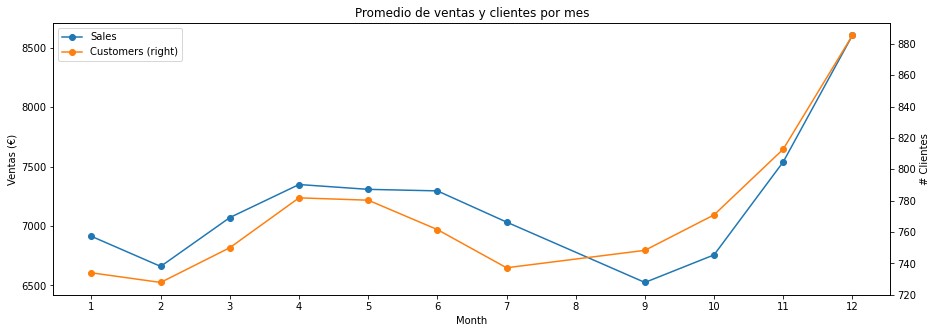

In [36]:
ax = df_eda.groupby('Month')[['Sales', 'Customers']].mean().plot(secondary_y=['Customers'], figsize=(15,5), marker='o')
ax.set_ylabel('Ventas (€)')
ax.right_ax.set_ylabel('# Clientes')
ax.set_xticks(range(1,13))
plt.title('Promedio de ventas y clientes por mes');

In [ ]:
#https://www.kaggle.com/code/ashishpatel26/rossman-stores-sales-analysis
#https://www.kaggle.com/code/jefersonyehuda/eda-prediction-with-prophet
#https://www.kaggle.com/code/arcticai/rossmann-sales-analysis-with-facebook-prophet

In [7]:
#Cuantas tiendas hay?
df_eda.Store.nunique()
print(f"Hay {df_eda.Store.nunique()} tiendas")

Hay 1115 tiendas


In [8]:
#Revisar cuantos clientes y ventas en promedio tiene cada tienda y cual es la mas alta
df_store = df_eda.groupby('Store').agg({'Sales': 'mean',
                                        'Customers': 'mean'}).sort_values(by='Sales', ascending=False).reset_index()
df_store['avg_customer_sales'] = df_store['Sales']/df_store['Customers']
df_store.rename(columns={'Sales': 'avg_Sales',
                         'Customers' : 'avg_Customers'}, inplace=True)
df_store['Store'] = df_store['Store'].astype(str) 
df_store.head(15)

,Store,avg_Sales,avg_Customers,avg_customer_sales
0,1114,21508.727273,3199.833333,6.721827
1,262,20909.037618,3332.316614,6.274625
2,817,20697.415094,2890.362264,7.160838
3,842,19979.850575,1181.028736,16.917328
4,251,19722.722433,2490.680608,7.918608
5,788,18310.162264,1711.184906,10.700283
6,562,18287.094044,3109.987461,5.880118
7,513,17753.528302,2005.796226,8.851113
8,383,17355.068441,2172.893536,7.987077
9,756,17314.973384,2409.323194,7.186655


In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

In [23]:
def grafico_store(tabla,variable,title):
  plt.figure(figsize=(10,6))
  plt.title(title)
  temp = tabla.sort_values(by=variable, ascending=False)
  sns.barplot(data=temp.head(5), x=variable, y='Store', 
    color='#69b3a2')

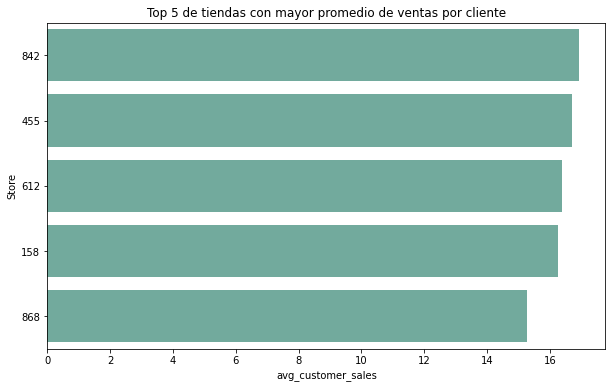

In [24]:
grafico_store(df_store,'avg_customer_sales','Top 5 de tiendas con mayor promedio de ventas por cliente')

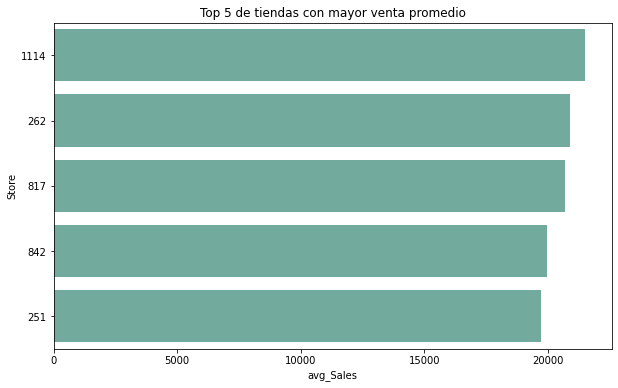

In [25]:
grafico_store(df_store,'avg_Sales','Top 5 de tiendas con mayor venta promedio')

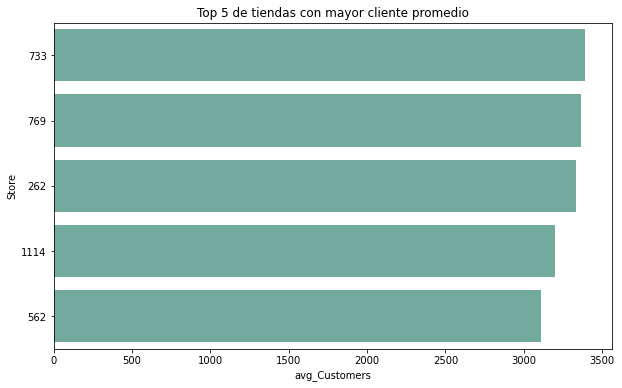

In [26]:
grafico_store(df_store,'avg_Customers','Top 5 de tiendas con mayor cliente promedio')

In [ ]:
import random

random.seed(1992)

data = ross_df.sample(frac=0.90)
data_unseen = ross_df.drop(data.index)

data.reset_index(inplace=True, drop=True)
data_unseen.reset_index(inplace=True, drop=True)

# print the revised shape
print('Data for Modeling: ' + str(data.shape))
print('Unseen Data For Predictions: ' + str(data_unseen.shape))

Data for Modeling: (915488, 9)
Unseen Data For Predictions: (101721, 9)


In [ ]:
ross_df = data

In [ ]:
ross_df

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,263,7,2015-04-26,0,0,0,0.0,0,0.0
1,178,1,2015-07-27,15255,1176,1,1.0,0,1.0
2,803,3,2015-04-01,8693,641,1,1.0,0,1.0
3,146,4,2015-04-23,6237,588,1,0.0,0,0.0
4,292,3,2015-07-29,0,0,0,1.0,0,1.0
...,...,...,...,...,...,...,...,...,...
126288,67,1,2015-07-06,7519,780,1,0.0,0,0.0
126289,592,4,2015-05-21,5998,740,1,1.0,0,0.0
126290,377,1,2015-06-22,6667,868,1,0.0,0,0.0
126291,248,5,2015-07-17,8325,1083,1,1.0,0,0.0


In [ ]:
store_df

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1110,1111,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1111,1112,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1113,1114,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


Let's merge the information from `store_df` into `train_df` and `test_df`.

In [ ]:
merged_df = ross_df.merge(store_df, how='left', on='Store')

In [ ]:
merged_df

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,263,7,2015-04-26,0,0,0,0.0,0,0.0,a,c,1140.0,5.0,2013.0,1,40.0,2014.0,"Jan,Apr,Jul,Oct"
1,178,1,2015-07-27,15255,1176,1,1.0,0,1.0,d,a,1710.0,NaN,NaN,0,NaN,NaN,NaN
2,803,3,2015-04-01,8693,641,1,1.0,0,1.0,d,a,1760.0,NaN,NaN,1,10.0,2014.0,"Mar,Jun,Sept,Dec"
3,146,4,2015-04-23,6237,588,1,0.0,0,0.0,d,c,8050.0,10.0,1961.0,1,48.0,2012.0,"Jan,Apr,Jul,Oct"
4,292,3,2015-07-29,0,0,0,1.0,0,1.0,a,a,1100.0,6.0,2009.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126288,67,1,2015-07-06,7519,780,1,0.0,0,0.0,a,c,410.0,2.0,2006.0,0,NaN,NaN,NaN
126289,592,4,2015-05-21,5998,740,1,1.0,0,0.0,a,a,2540.0,6.0,2005.0,0,NaN,NaN,NaN
126290,377,1,2015-06-22,6667,868,1,0.0,0,0.0,a,c,100.0,6.0,2010.0,1,18.0,2010.0,"Feb,May,Aug,Nov"
126291,248,5,2015-07-17,8325,1083,1,1.0,0,0.0,a,c,340.0,9.0,2012.0,1,40.0,2012.0,"Jan,Apr,Jul,Oct"


## Preprocessing and Feature Engineering

Let's take a look at the available columns, and figure out if we can create new columns or apply any useful transformations.

In [ ]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 126293 entries, 0 to 126292
Data columns (total 18 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Store                      126293 non-null  int64  
 1   DayOfWeek                  126293 non-null  int64  
 2   Date                       126293 non-null  object 
 3   Sales                      126293 non-null  int64  
 4   Customers                  126293 non-null  int64  
 5   Open                       126293 non-null  int64  
 6   Promo                      126292 non-null  float64
 7   StateHoliday               126292 non-null  object 
 8   SchoolHoliday              126292 non-null  float64
 9   StoreType                  126293 non-null  object 
 10  Assortment                 126293 non-null  object 
 11  CompetitionDistance        125952 non-null  float64
 12  CompetitionOpenSinceMonth  86210 non-null   float64
 13  CompetitionOpenSinceYear   86


### Date

First, let's convert `Date` to a `datecolumn` and extract different parts of the date.

In [ ]:
def split_date(df):
    df['Date'] = pd.to_datetime(df['Date'])
    df['Year'] = df.Date.dt.year
    df['Month'] = df.Date.dt.month
    df['Day'] = df.Date.dt.day
    df['WeekOfYear'] = df.Date.dt.isocalendar().week

In [ ]:
split_date(merged_df)

In [ ]:
merged_df

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear
0,263,7,2015-04-26,0,0,0,0.0,0,0.0,a,c,1140.0,5.0,2013.0,1,40.0,2014.0,"Jan,Apr,Jul,Oct",2015,4,26,17
1,178,1,2015-07-27,15255,1176,1,1.0,0,1.0,d,a,1710.0,NaN,NaN,0,NaN,NaN,NaN,2015,7,27,31
2,803,3,2015-04-01,8693,641,1,1.0,0,1.0,d,a,1760.0,NaN,NaN,1,10.0,2014.0,"Mar,Jun,Sept,Dec",2015,4,1,14
3,146,4,2015-04-23,6237,588,1,0.0,0,0.0,d,c,8050.0,10.0,1961.0,1,48.0,2012.0,"Jan,Apr,Jul,Oct",2015,4,23,17
4,292,3,2015-07-29,0,0,0,1.0,0,1.0,a,a,1100.0,6.0,2009.0,0,NaN,NaN,NaN,2015,7,29,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126288,67,1,2015-07-06,7519,780,1,0.0,0,0.0,a,c,410.0,2.0,2006.0,0,NaN,NaN,NaN,2015,7,6,28
126289,592,4,2015-05-21,5998,740,1,1.0,0,0.0,a,a,2540.0,6.0,2005.0,0,NaN,NaN,NaN,2015,5,21,21
126290,377,1,2015-06-22,6667,868,1,0.0,0,0.0,a,c,100.0,6.0,2010.0,1,18.0,2010.0,"Feb,May,Aug,Nov",2015,6,22,26
126291,248,5,2015-07-17,8325,1083,1,1.0,0,0.0,a,c,340.0,9.0,2012.0,1,40.0,2012.0,"Jan,Apr,Jul,Oct",2015,7,17,29


### Store Open/Closed

Next, notice that the sales are zero whenever the store is closed.

In [ ]:
merged_df[merged_df["Open"] == 0]["Sales"].value_counts()

0    23132
Name: Sales, dtype: int64

Instead of trying to model this relationship, it would be better to hard-code it in our predictions, and remove the rows where the store is closed. We won't remove any rows from the test set, since we need to make predictions for every row.

In [ ]:
merged_df = merged_df[merged_df["Open"] == 1].copy()

### Competition

Next, we can use the columns `CompetitionOpenSince[Month/Year]` columns from `store_df` to compute the number of months for which a competitor has been open near the store.

In [ ]:
def comp_months(df):
    df['CompetitionOpen'] = 12 * (df.Year - df.CompetitionOpenSinceYear) + (df.Month - df.CompetitionOpenSinceMonth)
    df['CompetitionOpen'] = df['CompetitionOpen'].map(lambda x: 0 if x < 0 else x).fillna(0)

In [ ]:
comp_months(merged_df)

In [ ]:
merged_df

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear,CompetitionOpen
1,178,1,2015-07-27,15255,1176,1,1.0,0,1.0,d,a,1710.0,NaN,NaN,0,NaN,NaN,NaN,2015,7,27,31,0.0
2,803,3,2015-04-01,8693,641,1,1.0,0,1.0,d,a,1760.0,NaN,NaN,1,10.0,2014.0,"Mar,Jun,Sept,Dec",2015,4,1,14,0.0
3,146,4,2015-04-23,6237,588,1,0.0,0,0.0,d,c,8050.0,10.0,1961.0,1,48.0,2012.0,"Jan,Apr,Jul,Oct",2015,4,23,17,642.0
5,645,6,2015-07-18,9217,1231,1,0.0,0,0.0,a,a,90.0,NaN,NaN,1,45.0,2009.0,"Feb,May,Aug,Nov",2015,7,18,29,0.0
6,1092,5,2015-05-08,12109,1166,1,1.0,0,0.0,a,a,300.0,7.0,2000.0,1,40.0,2014.0,"Jan,Apr,Jul,Oct",2015,5,8,19,178.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126288,67,1,2015-07-06,7519,780,1,0.0,0,0.0,a,c,410.0,2.0,2006.0,0,NaN,NaN,NaN,2015,7,6,28,113.0
126289,592,4,2015-05-21,5998,740,1,1.0,0,0.0,a,a,2540.0,6.0,2005.0,0,NaN,NaN,NaN,2015,5,21,21,119.0
126290,377,1,2015-06-22,6667,868,1,0.0,0,0.0,a,c,100.0,6.0,2010.0,1,18.0,2010.0,"Feb,May,Aug,Nov",2015,6,22,26,60.0
126291,248,5,2015-07-17,8325,1083,1,1.0,0,0.0,a,c,340.0,9.0,2012.0,1,40.0,2012.0,"Jan,Apr,Jul,Oct",2015,7,17,29,34.0


Let's view the results of the new columns we've created.

In [ ]:
merged_df[['Date', 'CompetitionDistance', 'CompetitionOpenSinceYear', 'CompetitionOpenSinceMonth', 'CompetitionOpen']].sample(20)

,Date,CompetitionDistance,CompetitionOpenSinceYear,CompetitionOpenSinceMonth,CompetitionOpen
76541,2015-06-08,3050.0,NaN,NaN,0.0
50340,2015-07-25,760.0,2005.0,12.0,115.0
91073,2015-04-04,940.0,2004.0,4.0,132.0
110363,2015-04-18,2100.0,NaN,NaN,0.0
24123,2015-07-01,6630.0,NaN,NaN,0.0
96914,2015-06-27,9070.0,2011.0,4.0,50.0
59471,2015-05-16,50.0,NaN,NaN,0.0
4242,2015-06-26,16210.0,2010.0,11.0,55.0
3218,2015-06-09,1600.0,2006.0,6.0,108.0
35730,2015-06-28,1270.0,2014.0,5.0,13.0


### Additional Promotion

We can also add some additional columns to indicate how long a store has been running `Promo2` and whether a new round of `Promo2` starts in the current month.

In [ ]:
def check_promo_month(row):
    month2str = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun',              
                 7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}
    try:
        months = (row['PromoInterval'] or '').split(',')
        if row['Promo2Open'] and month2str[row['Month']] in months:
            return 1
        else:
            return 0
    except Exception:
        return 0

def promo_cols(df):
    # Months since Promo2 was open
    df['Promo2Open'] = 12 * (df.Year - df.Promo2SinceYear) +  (df.WeekOfYear - df.Promo2SinceWeek)*7/30.5
    df['Promo2Open'] = df['Promo2Open'].map(lambda x: 0 if x < 0 else x).fillna(0) * df['Promo2']
    # Whether a new round of promotions was started in the current month
    df['IsPromo2Month'] = df.apply(check_promo_month, axis=1) * df['Promo2']

In [ ]:
promo_cols(merged_df)

Let's view the results of the columns we've created.

In [ ]:
merged_df[['Date', 'Promo2', 'Promo2SinceYear', 'Promo2SinceWeek', 'PromoInterval', 'Promo2Open', 'IsPromo2Month']].sample(20)

,Date,Promo2,Promo2SinceYear,Promo2SinceWeek,PromoInterval,Promo2Open,IsPromo2Month
47682,2015-06-03,0,NaN,NaN,NaN,0.000000,0
106757,2015-05-04,1,2011.0,5.0,"Feb,May,Aug,Nov",51.213115,1
119142,2015-07-07,0,NaN,NaN,NaN,0.000000,0
107459,2015-07-20,0,NaN,NaN,NaN,0.000000,0
83879,2015-03-31,0,NaN,NaN,NaN,0.000000,0
81573,2015-07-06,1,2013.0,31.0,"Feb,May,Aug,Nov",23.311475,0
19495,2015-04-14,1,2014.0,40.0,"Jan,Apr,Jul,Oct",6.491803,1
104142,2015-04-07,0,NaN,NaN,NaN,0.000000,0
100922,2015-07-15,1,2015.0,18.0,"Feb,May,Aug,Nov",2.524590,0
35754,2015-06-25,1,2013.0,5.0,"Feb,May,Aug,Nov",28.819672,0


The features related to competition and promotion are now much more useful.

### Input and Target Columns

Let's select the columns that we'll use for training.

In [ ]:
merged_df.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval', 'Year', 'Month', 'Day',
       'WeekOfYear', 'CompetitionOpen', 'Promo2Open', 'IsPromo2Month'],
      dtype='object')

In [ ]:
input_cols = ['Store', 'DayOfWeek', 'Promo', 'StateHoliday', 'SchoolHoliday', 
              'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpen', 
              'Day', 'Month', 'Year', 'WeekOfYear',  'Promo2', 
              'Promo2Open', 'IsPromo2Month']
target_col = 'Sales'

In [ ]:
inputs = merged_df[input_cols].copy()
targets = merged_df[target_col].copy()

Let's also identify numeric and categorical columns. Note that we can treat binary categorical columns (0/1) as numeric columns.

In [ ]:
numeric_cols = ['Store', 'Promo', 'SchoolHoliday', 
              'CompetitionDistance', 'CompetitionOpen', 'Promo2', 'Promo2Open', 'IsPromo2Month',
              'Day', 'Month', 'Year', 'WeekOfYear',  ]
categorical_cols = ['DayOfWeek', 'StateHoliday', 'StoreType', 'Assortment']

### Impute missing numerical data

In [ ]:
inputs[numeric_cols].isna().sum()

Store                    0
Promo                    1
SchoolHoliday            1
CompetitionDistance    278
CompetitionOpen          0
Promo2                   0
Promo2Open               0
IsPromo2Month            0
Day                      0
Month                    0
Year                     0
WeekOfYear               0
dtype: int64

Seems like competition distance is the only missing value, and we can simply fill it with the highest value (to indicate that competition is very far away).

In [ ]:
max_distance = inputs.CompetitionDistance.max()

In [ ]:
inputs['CompetitionDistance'].fillna(max_distance, inplace=True)

### Scale Numeric Values

Let's scale numeric values to the 0 to 1 range.

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
scaler = MinMaxScaler().fit(inputs[numeric_cols])

In [ ]:
inputs[numeric_cols] = scaler.transform(inputs[numeric_cols])

### Encode Categorical Columns

<img src="https://i.imgur.com/n8GuiOO.png" width="640">

Let's one-hot encode categorical columns.

In [ ]:
from sklearn.preprocessing import OneHotEncoder

In [ ]:
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore').fit(inputs[categorical_cols])
encoded_cols = list(encoder.get_feature_names_out(categorical_cols))

In [ ]:
inputs[encoded_cols] = encoder.transform(inputs[categorical_cols])

Finally, let's extract out all the numeric data for training.

In [ ]:
encoded_cols

['DayOfWeek_1',
 'DayOfWeek_2',
 'DayOfWeek_3',
 'DayOfWeek_4',
 'DayOfWeek_5',
 'DayOfWeek_6',
 'DayOfWeek_7',
 'StateHoliday_0',
 'StateHoliday_a',
 'StateHoliday_b',
 'StateHoliday_nan',
 'StoreType_a',
 'StoreType_b',
 'StoreType_c',
 'StoreType_d',
 'Assortment_a',
 'Assortment_b',
 'Assortment_c']

In [ ]:
X = inputs[numeric_cols + encoded_cols]

We haven't created a validation set yet, because we'll use K-fold cross validation.

In [ ]:
X.columns

Index(['Store', 'Promo', 'SchoolHoliday', 'CompetitionDistance',
       'CompetitionOpen', 'Promo2', 'Promo2Open', 'IsPromo2Month', 'Day',
       'Month', 'Year', 'WeekOfYear', 'DayOfWeek_1', 'DayOfWeek_2',
       'DayOfWeek_3', 'DayOfWeek_4', 'DayOfWeek_5', 'DayOfWeek_6',
       'DayOfWeek_7', 'StateHoliday_0', 'StateHoliday_a', 'StateHoliday_b',
       'StateHoliday_nan', 'StoreType_a', 'StoreType_b', 'StoreType_c',
       'StoreType_d', 'Assortment_a', 'Assortment_b', 'Assortment_c'],
      dtype='object')

## Gradient Boosting

We're now ready to train our gradient boosting machine (GBM) model. Here's how a GBM model works:

1. The average value of the target column and uses as an initial prediction every input.
2. The residuals (difference) of the predictions with the targets are computed.
3. A decision tree of limited depth is trained to **predict just the residuals** for each input.
4. Predictions from the decision tree are scaled using a parameter called the learning rate (this prevents overfitting)
5. Scaled predictions fro the tree are added to the previous predictions to obtain the new and improved predictions.
6. Steps 2 to 5 are repeated to create new decision trees, each of which is trained to predict just the residuals from the previous prediction.

The term "gradient" refers to the fact that each decision tree is trained with the purpose of reducing the loss from the previous iteration (similar to gradient descent). The term "boosting" refers the general technique of training new models to improve the results of an existing model. 


For a mathematical explanation of gradient boosting, check out the following resources:

- [XGBoost Documentation](https://xgboost.readthedocs.io/en/latest/tutorials/model.html)
- [Video Tutorials on StatQuest](https://www.youtube.com/watch?v=3CC4N4z3GJc&list=PLblh5JKOoLUJjeXUvUE0maghNuY2_5fY6)

Here's a visual representation of gradient boosting:

![](https://miro.medium.com/max/560/1*85QHtH-49U7ozPpmA5cAaw.png)



### Training

To train a GBM, we can use the `XGBRegressor` class from the [`XGBoost`](https://xgboost.readthedocs.io/en/latest/) library.

In [ ]:
from xgboost import XGBRegressor

In [ ]:
?XGBRegressor

In [ ]:
model = XGBRegressor(random_state=42, n_jobs=-1, n_estimators=20, max_depth=4)

Let's train the model using `model.fit`.

In [ ]:
%%time
model.fit(X, targets)

CPU times: user 4.38 s, sys: 45.1 ms, total: 4.43 s
Wall time: 2.42 s


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=4, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=20, n_jobs=-1,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, ...)

> <img src="https://www.deepnetts.com/blog/wp-content/uploads/2019/02/SupervisedLearning.png" width="480">

### Prediction

We can now make predictions and evaluate the model using `model.predict`.

In [ ]:
preds = model.predict(X)

In [ ]:
preds

array([9492.999 , 9329.108 , 5791.793 , ..., 6828.342 , 8227.326 ,
       6720.6016], dtype=float32)

### Evaluation

Let's evaluate the predictions using RMSE error.

In [ ]:
from sklearn.metrics import mean_squared_error

def rmse(a, b):
    return mean_squared_error(a, b, squared=False)

In [ ]:
rmse(preds, targets)

2352.778733990434

### Visualization

We can visualize individual trees using `plot_tree` (note: this requires the `graphviz` library to be installed).

In [ ]:
import matplotlib.pyplot as plt
from xgboost import plot_tree
from matplotlib.pylab import rcParams
%matplotlib inline

rcParams['figure.figsize'] = 30,30

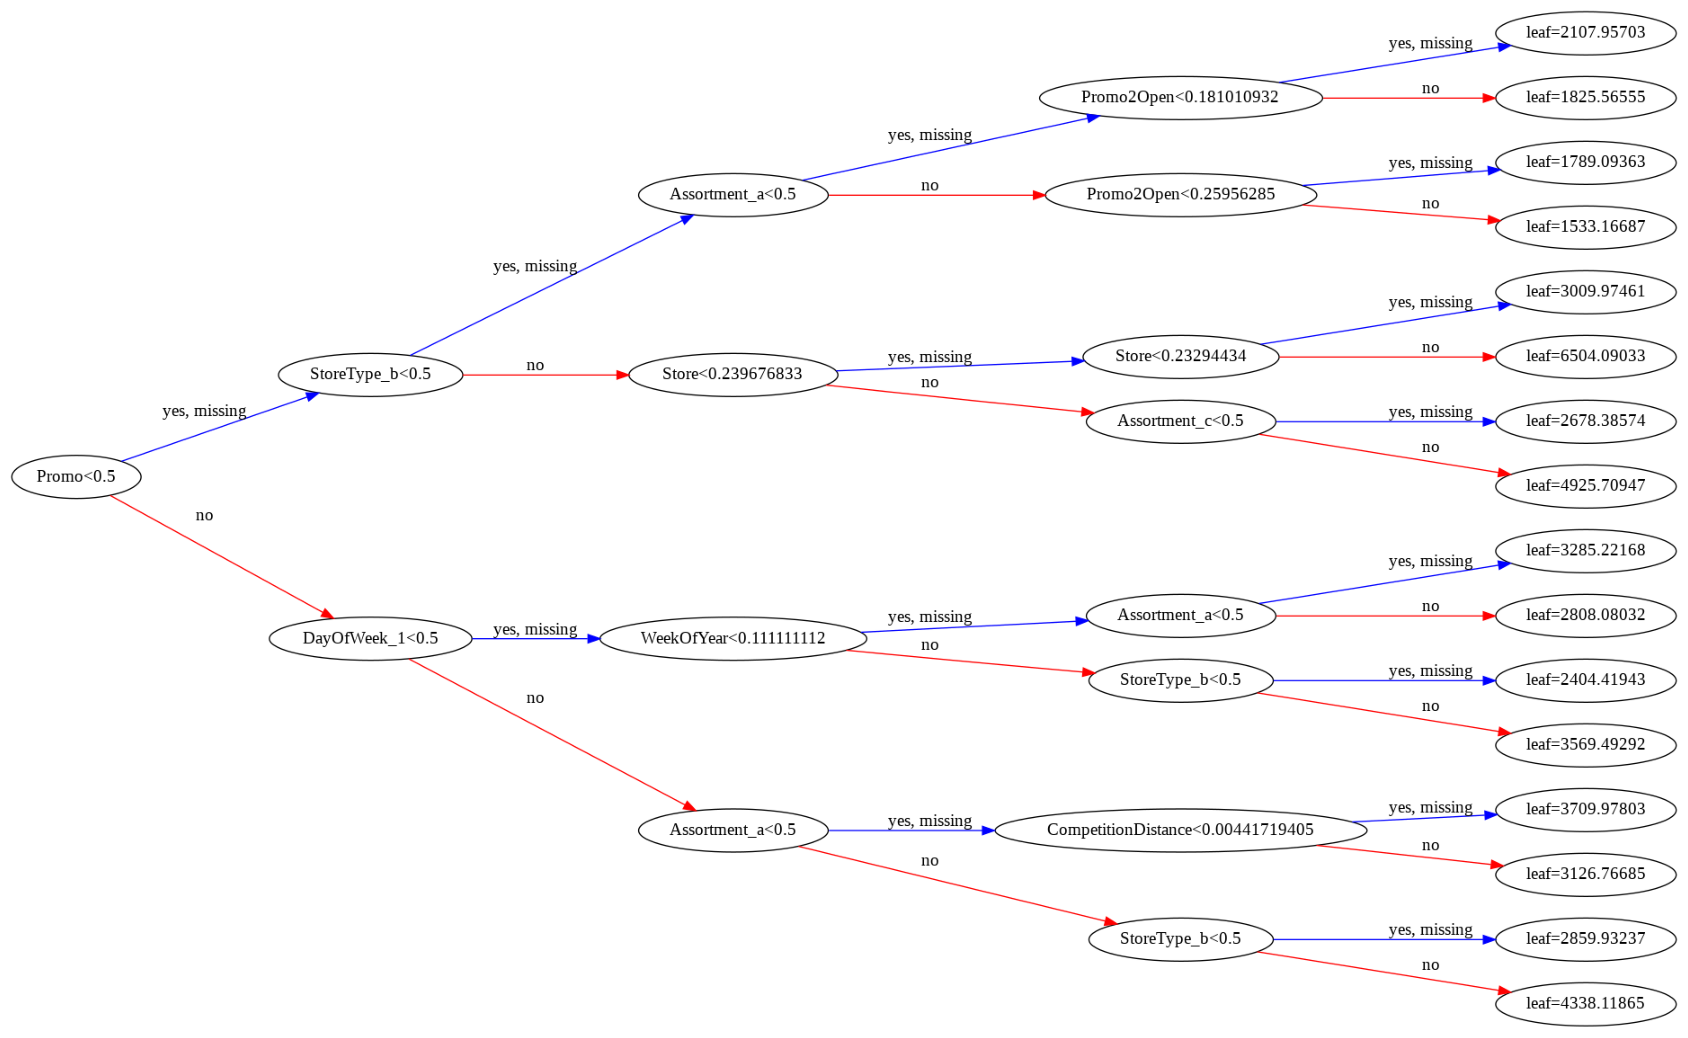

In [ ]:
plot_tree(model, rankdir='LR');

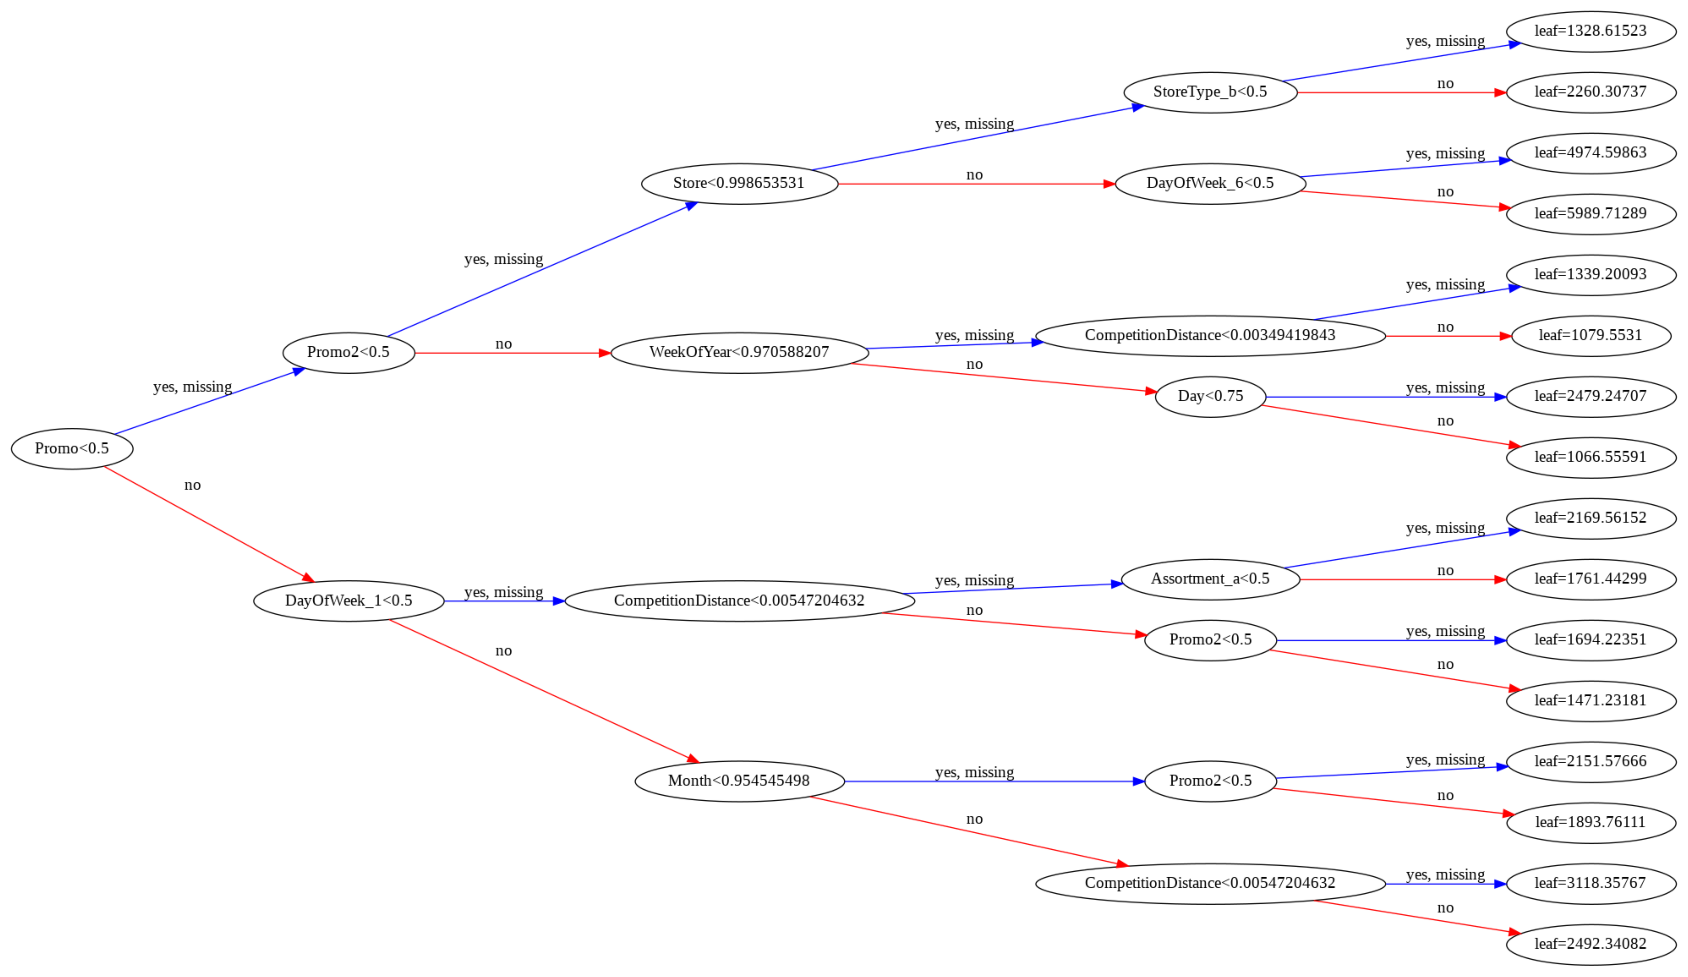

In [ ]:
plot_tree(model, rankdir='LR', num_trees=1);

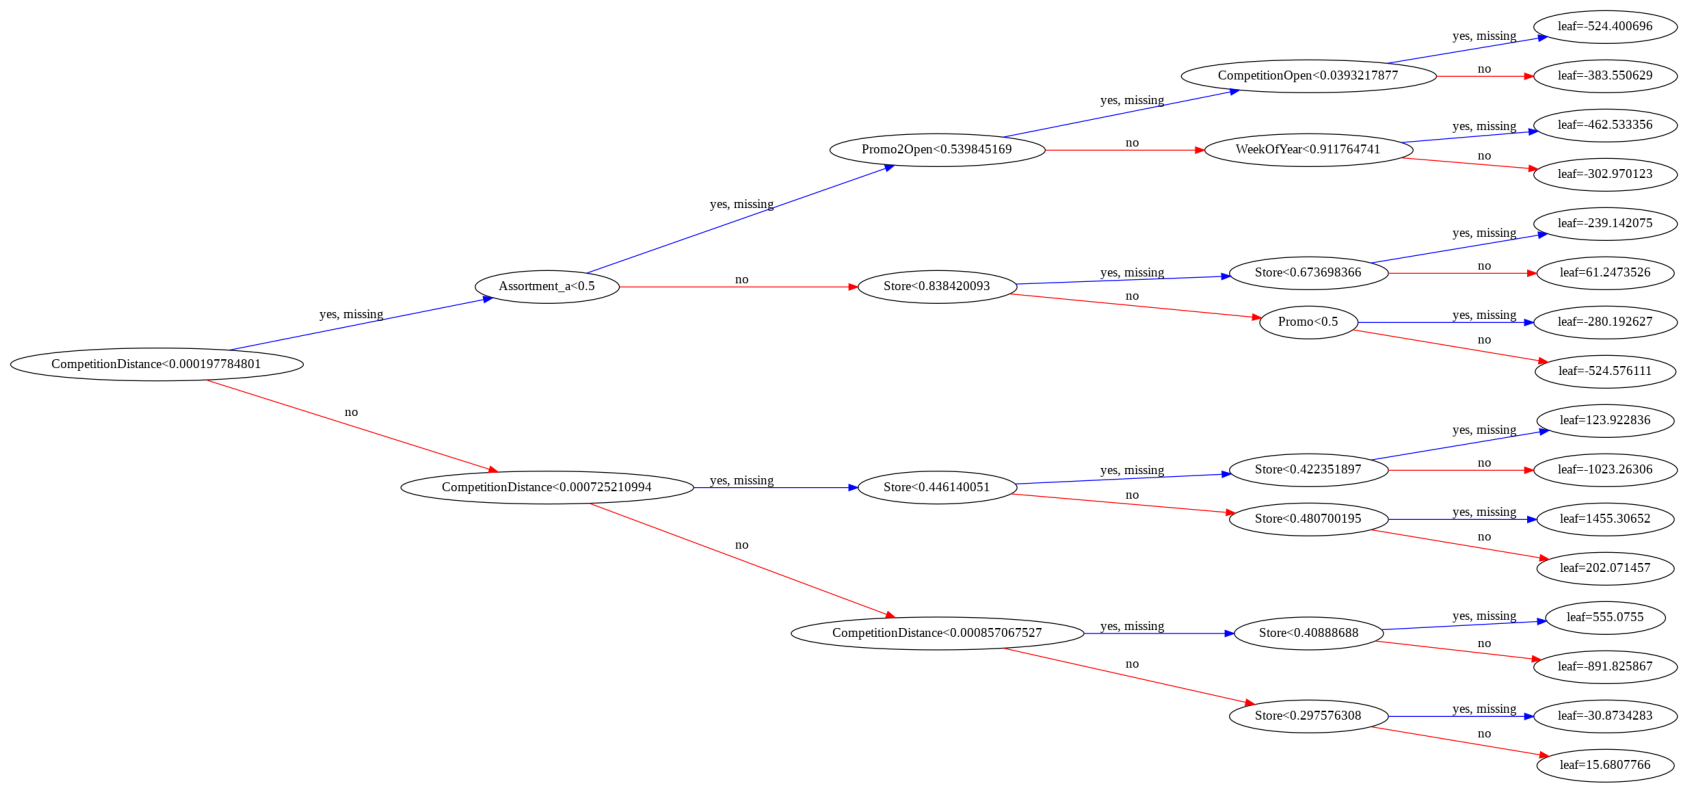

In [ ]:
plot_tree(model, rankdir='LR', num_trees=19);

Notice how the trees only compute residuals, and not the actual target value. We can also visualize the tree as text.

In [ ]:
trees = model.get_booster().get_dump()

In [ ]:
len(trees)

20

In [ ]:
print(trees[0])

0:[Promo<0.5] yes=1,no=2,missing=1
	1:[StoreType_b<0.5] yes=3,no=4,missing=3
		3:[Assortment_a<0.5] yes=7,no=8,missing=7
			7:[Promo2Open<0.181010932] yes=15,no=16,missing=15
				15:leaf=2107.95703
				16:leaf=1825.56555
			8:[Promo2Open<0.25956285] yes=17,no=18,missing=17
				17:leaf=1789.09363
				18:leaf=1533.16687
		4:[Store<0.239676833] yes=9,no=10,missing=9
			9:[Store<0.23294434] yes=19,no=20,missing=19
				19:leaf=3009.97461
				20:leaf=6504.09033
			10:[Assortment_c<0.5] yes=21,no=22,missing=21
				21:leaf=2678.38574
				22:leaf=4925.70947
	2:[DayOfWeek_1<0.5] yes=5,no=6,missing=5
		5:[WeekOfYear<0.111111112] yes=11,no=12,missing=11
			11:[Assortment_a<0.5] yes=23,no=24,missing=23
				23:leaf=3285.22168
				24:leaf=2808.08032
			12:[StoreType_b<0.5] yes=25,no=26,missing=25
				25:leaf=2404.41943
				26:leaf=3569.49292
		6:[Assortment_a<0.5] yes=13,no=14,missing=13
			13:[CompetitionDistance<0.00441719405] yes=27,no=28,missing=27
				27:leaf=3709.97803
				28:leaf=3126.76685
		

### Feature importance

Just like decision trees and random forests, XGBoost also provides a feature importance score for each column in the input.

In [ ]:
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

In [ ]:
importance_df#.head(10)

,feature,importance
1,Promo,0.336737
12,DayOfWeek_1,0.118433
24,StoreType_b,0.086317
27,Assortment_a,0.053342
0,Store,0.042934
6,Promo2Open,0.041514
3,CompetitionDistance,0.039750
8,Day,0.038409
26,StoreType_d,0.038287
9,Month,0.031523


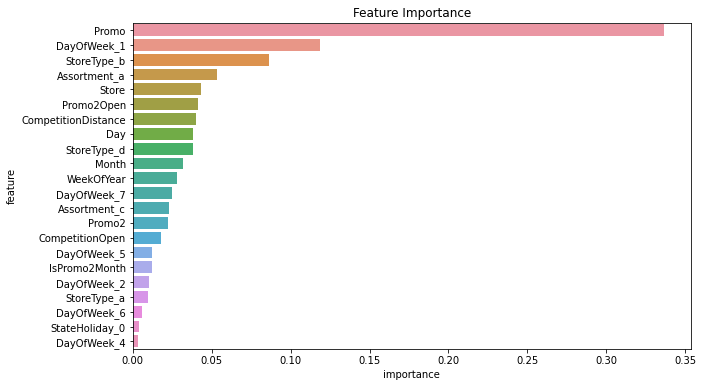

In [ ]:
import seaborn as sns
plt.figure(figsize=(10,6))
plt.title('Feature Importance')
sns.barplot(data=importance_df.head(22), x='importance', y='feature');

In [ ]:
var_final = importance_df[importance_df['importance']>0].feature.values

In [ ]:
X.head(2)

,Store,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpen,Promo2,Promo2Open,IsPromo2Month,Day,Month,Year,WeekOfYear,DayOfWeek_1,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6,DayOfWeek_7,StateHoliday_0,StateHoliday_a,StateHoliday_b,StateHoliday_nan,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c
1,0.158887,1.0,1.0,0.022284,0.0,0.0,0.000000,0.0,0.866667,1.00,0.0,1.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
2,0.719928,1.0,1.0,0.022943,0.0,1.0,0.179417,0.0,0.000000,0.25,0.0,0.055556,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


## K Fold Cross Validation

Notice that we didn't create a validation set before training our XGBoost model. We'll use a different validation strategy this time, called K-fold cross validation ([source](https://vitalflux.com/k-fold-cross-validation-python-example/)):

![](https://vitalflux.com/wp-content/uploads/2020/08/Screenshot-2020-08-15-at-11.13.53-AM.png)

Scikit-learn provides utilities for performing K fold cross validation.

In [ ]:
from sklearn.model_selection import KFold

Let's define a helper function `train_and_evaluate` which trains a model the given parameters and returns the trained model, training error and validation error.

In [ ]:
def train_and_evaluate(X_train, train_targets, X_val, val_targets, **params):
    model = XGBRegressor(random_state=42, n_jobs=-1, **params)
    model.fit(X_train, train_targets)
    train_rmse = rmse(model.predict(X_train), train_targets)
    val_rmse = rmse(model.predict(X_val), val_targets)
    return model, train_rmse, val_rmse

Now, we can use the `KFold` utility to create the different training/validations splits and train a separate model for each fold.

In [ ]:
kfold = KFold(n_splits=5)

In [ ]:
models = []

for train_idxs, val_idxs in kfold.split(X):
    X_train, train_targets = X.iloc[train_idxs], targets.iloc[train_idxs]
    X_val, val_targets = X.iloc[val_idxs], targets.iloc[val_idxs]
    model, train_rmse, val_rmse = train_and_evaluate(X_train, 
                                                     train_targets, 
                                                     X_val, 
                                                     val_targets, 
                                                     max_depth=4, 
                                                     n_estimators=20)
    models.append(model)
    print('Train RMSE: {}, Validation RMSE: {}'.format(train_rmse, val_rmse))

Train RMSE: 2351.8279890315134, Validation RMSE: 2339.028590926564
Train RMSE: 2335.2785927555296, Validation RMSE: 2350.5446974959773
Train RMSE: 2343.349599232929, Validation RMSE: 2392.6395054638024
Train RMSE: 2331.522020025845, Validation RMSE: 2362.5135785470243
Train RMSE: 2364.564953902441, Validation RMSE: 2318.0687336017168


Let's also define a function to average predictions from the 5 different models.

In [ ]:
import numpy as np

def predict_avg(models, inputs):
    return np.mean([model.predict(inputs) for model in models], axis=0)

In [ ]:
preds = predict_avg(models, X)

In [ ]:
preds

array([9666.042 , 9556.235 , 5880.2686, ..., 7341.2944, 8194.064 ,
       6827.6787], dtype=float32)

We can now use `predict_avg` to make predictions for the test set.

## Hyperparameter Tuning and Regularization

Just like other machine learning models, there are several hyperparameters we can to adjust the capacity of model and reduce overfitting.

<img src="https://i.imgur.com/EJCrSZw.png" width="480">

Check out the following resources to learn more about hyperparameter supported by XGBoost:

- https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBRegressor
- https://xgboost.readthedocs.io/en/latest/parameter.html

In [ ]:
model

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=4, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=20, n_jobs=-1,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, ...)

In [ ]:
?XGBRegressor

Here's a helper function to test hyperparameters with K-fold cross validation.

In [ ]:
def test_params_kfold(n_splits, **params):
    train_rmses, val_rmses, models = [], [], []
    kfold = KFold(n_splits)
    for train_idxs, val_idxs in kfold.split(X):
        X_train, train_targets = X.iloc[train_idxs], targets.iloc[train_idxs]
        X_val, val_targets = X.iloc[val_idxs], targets.iloc[val_idxs]
        model, train_rmse, val_rmse = train_and_evaluate(X_train, train_targets, X_val, val_targets, **params)
        models.append(model)
        train_rmses.append(train_rmse)
        val_rmses.append(val_rmse)
    print('Train RMSE: {}, Validation RMSE: {}'.format(np.mean(train_rmses), np.mean(val_rmses)))
    return models

Since it may take a long time to perform 5-fold cross validation for each set of parameters we wish to try, we'll just pick a random 10% sample of the dataset as the validation set.

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_val, train_targets, val_targets = train_test_split(X, targets, test_size=0.1)

In [ ]:
def test_params(**params):
    model = XGBRegressor(n_jobs=-1, random_state=42, **params)
    model.fit(X_train, train_targets)
    train_rmse = rmse(model.predict(X_train), train_targets)
    val_rmse = rmse(model.predict(X_val), val_targets)
    print('Train RMSE: {}, Validation RMSE: {}'.format(train_rmse, val_rmse))

#### `n_estimators`

The number of trees to be created. More trees = greater capacity of the model.


In [ ]:
test_params(n_estimators=10)

Train RMSE: 2347.7837977369086, Validation RMSE: 2354.1973166271846


In [ ]:
test_params(n_estimators=30)

Train RMSE: 1879.8328704195342, Validation RMSE: 1884.3272315357701


In [ ]:
test_params(n_estimators=100)

Train RMSE: 1173.7496872371614, Validation RMSE: 1190.1988784298792


In [ ]:
test_params(n_estimators=240)

Train RMSE: 894.4398371734183, Validation RMSE: 921.3636336032914


#### `max_depth`

As you increase the max depth of each tree, the capacity of the tree increases and it can capture more information about the training set.

In [ ]:
test_params(max_depth=2)

Train RMSE: 2356.5432042991365, Validation RMSE: 2358.443476409651


In [ ]:
test_params(max_depth=5)

Train RMSE: 1429.221585020613, Validation RMSE: 1438.0046783471294


In [ ]:
test_params(max_depth=10)

Train RMSE: 681.6080604181075, Validation RMSE: 785.3919681378366


#### `learning_rate`

The scaling factor to be applied to the prediction of each tree. A very high learning rate (close to 1) will lead to overfitting, and a low learning rate (close to 0) will lead to underfitting.

In [ ]:
test_params(n_estimators=50, learning_rate=0.01)

Train RMSE: 5044.557639667986, Validation RMSE: 5043.679173757021


In [ ]:
test_params(n_estimators=50, learning_rate=0.1)

Train RMSE: 2174.8411579625204, Validation RMSE: 2183.070862283937


In [ ]:
test_params(n_estimators=50, learning_rate=0.3)

Train RMSE: 1564.1779050559323, Validation RMSE: 1571.828087418633


In [ ]:
test_params(n_estimators=50, learning_rate=0.9)

Train RMSE: 1092.0784027789084, Validation RMSE: 1108.9203569348988


In [ ]:
test_params(n_estimators=50, learning_rate=0.99)

Train RMSE: 1167.4539465822174, Validation RMSE: 1193.0688429265642


#### `booster`

Instead of using Decision Trees, XGBoost can also train a linear model for each iteration. This can be configured using `booster`.

In [ ]:
test_params(booster='gblinear')

Train RMSE: 2728.0655586680596, Validation RMSE: 2729.4216019805376


Clearly, a linear model is not well suited for this dataset.

> **EXERCISE**: Exeperiment with other hyperparameters like `gamma`, `min_child_weight`, `max_delta_step`, `subsample`, `colsample_bytree` etc. and find their optimal values. Learn more about them here: https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBRegressor

## Putting it Together and Making Predictions

Let's train a final model on the entire training set with custom hyperparameters. 

In [ ]:
#nos quedamos solo con las variables importantes:
var_final

array(['Promo', 'DayOfWeek_1', 'StoreType_b', 'Assortment_a', 'Store',
       'Promo2Open', 'CompetitionDistance', 'Day', 'StoreType_d', 'Month',
       'WeekOfYear', 'DayOfWeek_7', 'Assortment_c', 'Promo2',
       'CompetitionOpen', 'DayOfWeek_5', 'IsPromo2Month', 'DayOfWeek_2',
       'StoreType_a', 'DayOfWeek_6', 'StateHoliday_0', 'DayOfWeek_4'],
      dtype=object)

In [ ]:
model = XGBRegressor(n_jobs=-1, random_state=42, n_estimators=1000, 
                     learning_rate=0.2, max_depth=10, subsample=0.9, 
                     colsample_bytree=0.7)

In [ ]:
%%time
model.fit(X, targets)

CPU times: user 7min 33s, sys: 1.89 s, total: 7min 35s
Wall time: 3min 56s


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.7,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.2, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=10, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=-1, num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, ...)

## Summary and References

![](https://miro.medium.com/max/560/1*85QHtH-49U7ozPpmA5cAaw.png)

The following topics were covered in this tutorial:

- Downloading a real-world dataset from a Kaggle competition
- Performing feature engineering and prepare the dataset for training
- Training and interpreting a gradient boosting model using XGBoost
- Training with KFold cross validation and ensembling results
- Configuring the gradient boosting model and tuning hyperparamters

Check out these resources to learn more: 

- https://albertum.medium.com/l1-l2-regularization-in-xgboost-regression-7b2db08a59e0
- https://machinelearningmastery.com/evaluate-gradient-boosting-models-xgboost-python/
- https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBRegressor
- https://xgboost.readthedocs.io/en/latest/parameter.html
- https://www.kaggle.com/xwxw2929/rossmann-sales-top1


In [ ]:
X.columns

Index(['Store', 'Promo', 'SchoolHoliday', 'CompetitionDistance',
       'CompetitionOpen', 'Promo2', 'Promo2Open', 'IsPromo2Month', 'Day',
       'Month', 'Year', 'WeekOfYear', 'DayOfWeek_1', 'DayOfWeek_2',
       'DayOfWeek_3', 'DayOfWeek_4', 'DayOfWeek_5', 'DayOfWeek_6',
       'DayOfWeek_7', 'StateHoliday_0', 'StateHoliday_a', 'StateHoliday_b',
       'StateHoliday_c', 'StoreType_a', 'StoreType_b', 'StoreType_c',
       'StoreType_d', 'Assortment_a', 'Assortment_b', 'Assortment_c'],
      dtype='object')

In [ ]:
max_distance

75860.0

In [ ]:
import joblib

#pickle

model_filename = 'model.pkl'
joblib.dump(model, model_filename)

joblib.dump(scaler, 'scaler_model.pkl')
joblib.dump(encoder, 'encoder.pkl')


print("Modelo grabado!")

Modelo grabado!


In [ ]:
#identificar las variables que entran
#guardar los onehotencoder
#guardar los scaler

In [ ]:
import sklearn

In [ ]:
import xgboost

In [ ]:
#versiones
print(np.__version__)
print(pd.__version__)
print(xgboost.__version__)
print(sklearn.__version__)


1.21.6
1.3.5
1.6.2
1.0.2
